A Neural Network that is trained on the differently oriented arrow signs, and classifies them accurately.

Loading images...
  Finished back_cropped: Loaded 45 images.
  Finished left_cropped: Loaded 53 images.
  Finished right_cropped: Loaded 55 images.

Total Dataset: 153 images loaded.
Feature vector size: 1024 (32x32x3 pixels)


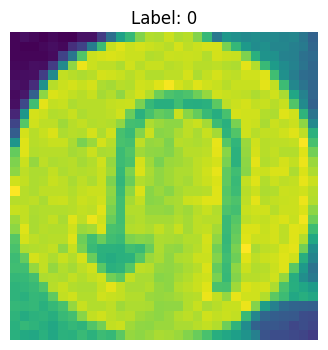


Training..

--- Evaluation ---
Model Accuracy: 96.77%
               precision    recall  f1-score   support

 back_cropped       1.00      0.91      0.95        11
 left_cropped       1.00      1.00      1.00        12
right_cropped       0.89      1.00      0.94         8

     accuracy                           0.97        31
    macro avg       0.96      0.97      0.96        31
 weighted avg       0.97      0.97      0.97        31



In [2]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt

#Dictionary - arrow types and labels
folders = {
    "back_cropped": 0,
    "left_cropped": 1,
    "right_cropped": 2
}

# The parent folder in drive
base_folder = "data"


# resize img   
IMG_SIZE = (32, 32) 


X_data = [] #  pixel values
y_data = [] #  labels 

print("Loading images...")

for folder_name, label in folders.items():
    
    # File path in drive
    folder_path = os.path.join(base_folder, folder_name)
    
    # IF NO folder, SKIP
    if not os.path.exists(folder_path):
        print(f"Warning: Folder not found: {folder_path}")
        continue

    # Get a list of ALL files in this folder
    files = os.listdir(folder_path)
    
    count = 0
    for filename in files:
        # if PNG file
        if filename.lower().endswith(".png"):
            
            #  full path
            file_path = os.path.join(folder_path, filename)
            
            try:
                img = cv2.imread(file_path)[:,:,0]
                
                if img is not None:
                    # Resize, Flatten, Normalize
                    img = cv2.resize(img, IMG_SIZE)
                    flat_img = img.flatten()
                    norm_img = flat_img / 255.0
                    
                    X_data.append(norm_img)
                    y_data.append(label)
                    count += 1
                else:
                    print(f"Warning: Could not open {filename}")
                    
            except Exception as e:
                print(f"Error reading {filename}: {e}")
                
    print(f"  Finished {folder_name}: Loaded {count} images.")

# Convert lists to np 
X = np.array(X_data)
y = np.array(y_data)


if len(X) == 0:
    print("Error: No images found. Check folder structure and paths.")
    exit()

print(f"\nTotal Dataset: {len(X)} images loaded.")
print(f"Feature vector size: {X.shape[1]} (32x32x3 pixels)")

#plot an img
image_index = 0
flat_image = X[image_index]  #  1D array of flattened image

# Reshape it back to (Height, Width, Channels)
# use IMG_SIZE (32, 32) and 3 channels
restored_image = flat_image.reshape(32, 32)
plt.figure(figsize=(4, 4))
plt.imshow(restored_image)
plt.title(f"Label: {y[image_index]}") 
plt.axis('off') 
plt.show()



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("\nTraining..")

#  Multi-Layer Perceptron Classifier
# hidden_layer_sizes=(100, 50): Two layers of "neurons"

clf = MLPClassifier(
    hidden_layer_sizes=(100, 50), 
    max_iter=500, 
    activation='relu', 
    solver='adam', 
    random_state=1
)

# Train the model
clf.fit(X_train, y_train)





print("\n--- Evaluation ---")
predictions = clf.predict(X_test)

# Calculate accuracy
acc = accuracy_score(y_test, predictions)
print(f"Model Accuracy: {acc*100:.2f}%")

# detailed report
target_names = list(folders.keys())
print(classification_report(y_test, predictions, target_names=target_names))

In [9]:
# Good to have
def relu(x):
    return np.maximum(x, 0)

In [24]:
M1, M2, M3 = clf.coefs_
b1, b2, b3 = clf.intercepts_
model_dir = "models/rec_sign"
np.savetxt(f"{model_dir}/M1.csv", M1, delimiter=",")
np.savetxt(f"{model_dir}/M2.csv", M2, delimiter=",")
np.savetxt(f"{model_dir}/M3.csv", M3, delimiter=",")
np.savetxt(f"{model_dir}/b1.csv", b1, delimiter=",")
np.savetxt(f"{model_dir}/b2.csv", b2, delimiter=",")
np.savetxt(f"{model_dir}/b3.csv", b3, delimiter=",")

In [22]:
def rec_sign(X):
    state = relu(np.matmul(X, rec_M1) + rec_b1)
    state = relu(np.matmul(state, rec_M2) + rec_b2)
    state = relu(np.matmul(state, rec_M3) + rec_b3)
    
    return np.argmax(state) # 0 = back, 1 = left, 2 = right